### 1. Importando bibliotecas

In [127]:
import pprint
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from itertools import batched

### 2. Funções

#### 2.1 Função de treinamento

In [128]:
def treinamento(X_train, y_train, qtd_atributos, tx_aprendizagem, epocas, batch, precisao, seed):
    """
        Argumentos:
        X_train -- matriz de entrada contendo as amostras de treino
        y_train -- vetor contendo os rótulos desejados para as amostras de treino
        qtd_atributos -- número de (features) presentes nas amostras
        tx_aprendizagem -- taxa de aprendizado, define o passo da atualização dos pesos
        epocas -- número máximo de ciclos completos sobre o conjunto de treinamento
        batch -- se True, o treinamento ocorre por lotes e se None, o treinamento ocorre por amostra
        precisao -- critério de parada baseado na diferença entre EQM de épocas consecutivas
        seed -- semente para inicialização dos pesos aleatórios
        
        Saída:
        parâmetros -- python tuple:
                        pesos -- vetor de pesos ajustados após o treinamento
                        epocas_executadas -- número total de épocas percorridas até a convergência
                        historico_erro -- lista com a evolução do erro de classificação ao longo das épocas
    """

    if seed is not None:                            # iniciando o vetor de pesos
        np.random.seed(seed)
        pesos = np.random.uniform(low=-1, high=1, size=((qtd_atributos + 1),))   # vetor de peso (atributos + bias)
    else:
        pesos = np.random.uniform(low=-1, high=1, size=((qtd_atributos + 1),))              # vetor de peso (atributos + bias)

    X = np.c_[np.ones(len(X_train)), X_train]
    y = y_train.flatten()                           # garantindo que é um vetor unidimensional

    evolucao_erro = []
    epoca = 0

    while epoca < epocas:

        if epoca > 0:
            EQM_anterior = erro_quadratico(X, y, pesos)
        else:
            EQM_anterior = 1e6              # tratamento para a primeira epoca
        
        if batch:                           # treinamento por lote (todas as amostras)
            u = np.dot(X, pesos)            # potencial de ativação
            erro = y - u
            pesos += tx_aprendizagem * np.dot(X.T, erro)
        
        else:                               # treinamento por amostra
            for amostra in range(len(X)):
                u = np.dot(pesos, X[amostra])   # potencial de ativação
                erro = y[amostra] - u
                pesos += tx_aprendizagem * erro * X[amostra]
        
        epoca += 1
        
        EQM_atual = erro_quadratico(X, y, pesos)
        
        predicoes = np.where(np.dot(X, pesos) >= 0, 1, -1)
        erro = np.count_nonzero(predicoes - y)
        evolucao_erro.append(erro/len(y))

        acuracia = np.mean(predicoes == y)
        
        if np.abs(EQM_atual - EQM_anterior) <= precisao:
            break
    
    return pesos, epoca, evolucao_erro, acuracia

def erro_quadratico(X, y, pesos):
    return np.mean((y - np.dot(X, pesos))**2)

#### 2.2 Função de teste

In [129]:
def teste(X_test, y_test, pesos):
    """
        Argumentos:
        X_test -- amostras de teste
        y_test -- resultados desejados das amostras de teste
        pesos -- vetor de pesos aprendidos durante o treinamento
        
        Saída:
        parâmetros -- python tuple:
                        acuracia -- percentual de acertos do modelo no conjunto de teste
                        predicoes -- vetor contendo as previsões do modelo para X_test
    """


    X_test = np.asarray(X_test)
    X = np.c_[np.ones(len(X_test)), X_test]

    y = np.asarray(y_test).flatten()                # garantindo que é um vetor unidimensional

    predicoes = np.where(np.dot(X, pesos) >= 0, 1, -1)

    acuracia = np.mean(predicoes == y)
    
    return acuracia

### 3. Experimentos

#### 3.1 Dataset 1

##### 3.1.1 Carregando os arquivos CSV

In [130]:
# Organizando variáveis e evitando sobrescrita
datasets = {}

def carregar_dataset(nome, train_path, test_path):
    df_train = pd.read_csv(train_path)
    df_test = pd.read_csv(test_path)
    
    datasets[nome] = {
        "X_train": df_train.drop("label", axis=1).values,
        "y_train": df_train["label"].values.reshape(1, -1).T,
        "X_test": df_test.drop("label", axis=1).values,
        "y_test": df_test["label"].values.reshape(1, -1).T
    }

carregar_dataset("dataset1", "arquivos_csv/train_dataset1.csv", "arquivos_csv/test_dataset1.csv")
carregar_dataset("dataset2", "arquivos_csv/train_dataset2.csv", "arquivos_csv/test_dataset2.csv")
carregar_dataset("dataset3", "arquivos_csv/train_dataset3.csv", "arquivos_csv/test_dataset3.csv")

# ------- Dataset #1 -------
X_train_1 = datasets["dataset1"]["X_train"]
y_train_1 = datasets["dataset1"]["y_train"]
X_test_1 = datasets["dataset1"]["X_test"]
y_test_1 = datasets["dataset1"]["y_test"]

# ------- Dataset #2 -------
X_train_2 = datasets["dataset2"]["X_train"]
y_train_2 = datasets["dataset2"]["y_train"]
X_test_2 = datasets["dataset2"]["X_test"]
y_test_2 = datasets["dataset2"]["y_test"]

# ------- Dataset #3 -------
X_train_3 = datasets["dataset3"]["X_train"]
y_train_3 = datasets["dataset3"]["y_train"]
X_test_3 = datasets["dataset3"]["X_test"]
y_test_3 = datasets["dataset3"]["y_test"]

##### 3.1.2 Analisando o dataset

In [131]:
# Tamanho do dataset
print("X_train_1: ", X_train_1.shape)
print("y_train_1: ", y_train_1.shape)
print("---------------------")
print("X_test_1: ", X_test_1.shape)
print("y_test_1: ", y_test_1.shape)

X_train_1:  (140, 2)
y_train_1:  (140, 1)
---------------------
X_test_1:  (60, 2)
y_test_1:  (60, 1)


In [132]:
# Razão de treino e teste
print("Razão de treino: ", X_train_1.shape[0]/(X_train_1.shape[0] + X_test_1.shape[0]))
print("Razão de teste: ", X_test_1.shape[0]/(X_train_1.shape[0] + X_test_1.shape[0]))

Razão de treino:  0.7
Razão de teste:  0.3


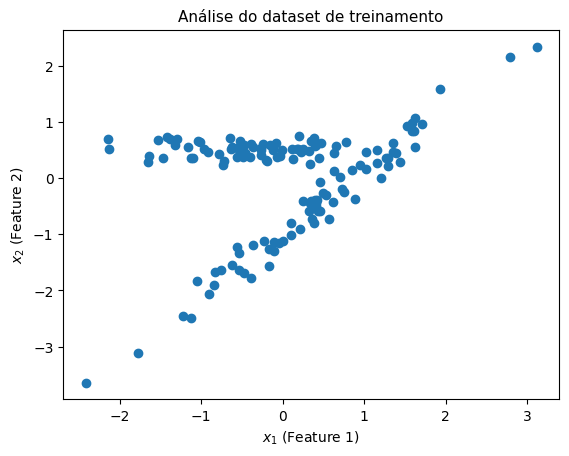

In [133]:
# Plot dos dados de treinamento
X_train_T = X_train_1.T
plt.scatter(X_train_T[0], X_train_T[1])
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Análise do dataset de treinamento", fontsize=11)
plt.show()

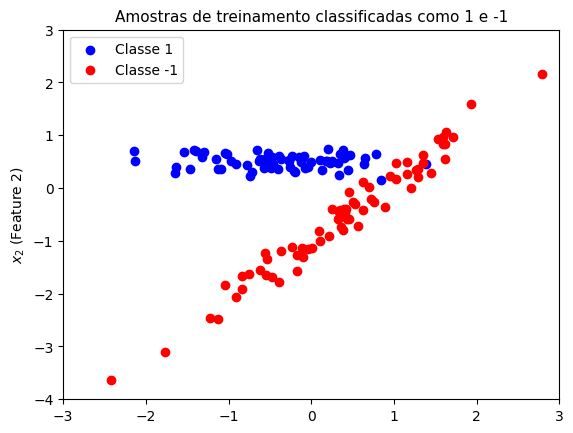

In [134]:
# Plot dos dados de treinamento
df_classe_1 = X_train_1[y_train_1.flatten() == 1]          # amostras da classe 1
df_classe_menos_1 = X_train_1[y_train_1.flatten() == -1]     # amostras da classe -1

plt.scatter(df_classe_1[:, 0], df_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df_classe_menos_1[:, 0], df_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Amostras de treinamento classificadas como 1 e -1", fontsize=11)
plt.xlim(-3, 3)
plt.ylim(-4, 3)
plt.legend()
plt.show()

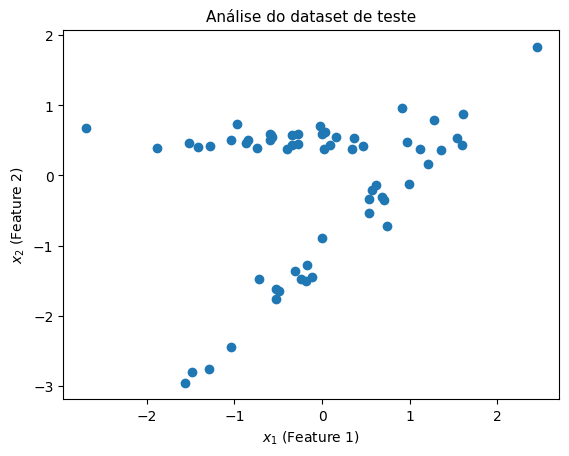

In [135]:
# Plot dos dados de teste
X_test_T = X_test_1.T
plt.scatter(X_test_T[0], X_test_T[1])
plt.xlabel('$x_1$ (Feature 1)', fontsize=10)
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Análise do dataset de teste", fontsize=11)
plt.show()

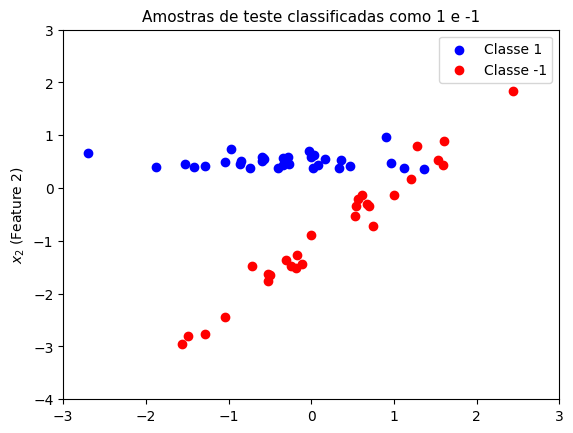

In [136]:
# Plot dos dados de teste
df_classe_1 = X_test_1[y_test_1.flatten() == 1]          # amostras da classe 1
df_classe_menos_1 = X_test_1[y_test_1.flatten() == -1]     # amostras da classe -1

plt.scatter(df_classe_1[:, 0], df_classe_1[:, 1], color='blue', label='Classe 1')
plt.scatter(df_classe_menos_1[:, 0], df_classe_menos_1[:, 1], color='red', label='Classe -1')
plt.ylabel('$x_2$ (Feature 2)', fontsize=10)
plt.title("Amostras de teste classificadas como 1 e -1", fontsize=11)
plt.xlim(-3, 3)
plt.ylim(-4, 3)
plt.legend()
plt.show()

##### 3.1.3 Treinando o ADALINE

###### 3.1.3.1 Aprendizado por lote

In [137]:
qtd_atributos = X_train_1.shape[1]
tx_aprendizagem = 0.001
epocas = 100
batch = True
precisao = 0.001
seed = 16

resultado_treino_lote = treinamento(X_train_1, y_train_1, qtd_atributos, tx_aprendizagem, epocas, batch, precisao, seed)    # return pesos, epoca, evolucao_erro, acuracia
print(f"Acurácia no treino por lote: {resultado_treino_lote[3]:.3%}")

Acurácia no treino por lote: 95.000%


###### 3.1.3.2 Aprendizado por amostra

In [138]:
qtd_atributos = X_train_1.shape[1]
tx_aprendizagem = 0.001
epocas = 100
batch = False
precisao = 0.001
seed = 16

resultado_treino_amostra = treinamento(X_train_1, y_train_1, qtd_atributos, tx_aprendizagem, epocas, batch, precisao, seed)     # return pesos, epoca, evolucao_erro, acuracia
print(f"Acurácia no treino por lote: {resultado_treino_amostra[3]:.3%}")

Acurácia no treino por lote: 95.000%


###### 3.1.3.3 Evolução do erro de treinamento

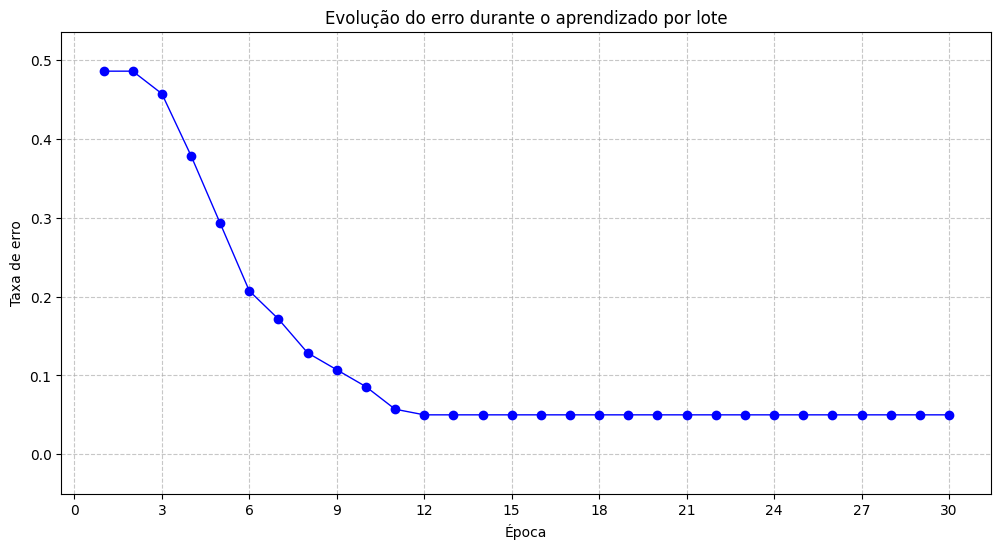

In [139]:
# Aprendizado por lote
x = np.array(range(1, resultado_treino_lote[1] + 1))
y = resultado_treino_lote[2]

plt.figure(figsize=(12, 6))
plt.plot(x, y, 'b-o', linewidth=1, markersize=5, markeredgewidth=2)
plt.title('Evolução do erro durante o aprendizado por lote', fontsize=12)
plt.xlabel('Época', fontsize=10)
plt.ylabel('Taxa de erro', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, max(x)+1, max(1, len(x)//10)))
plt.ylim(-0.05, min(1.05, max(y)+0.05))
plt.show()

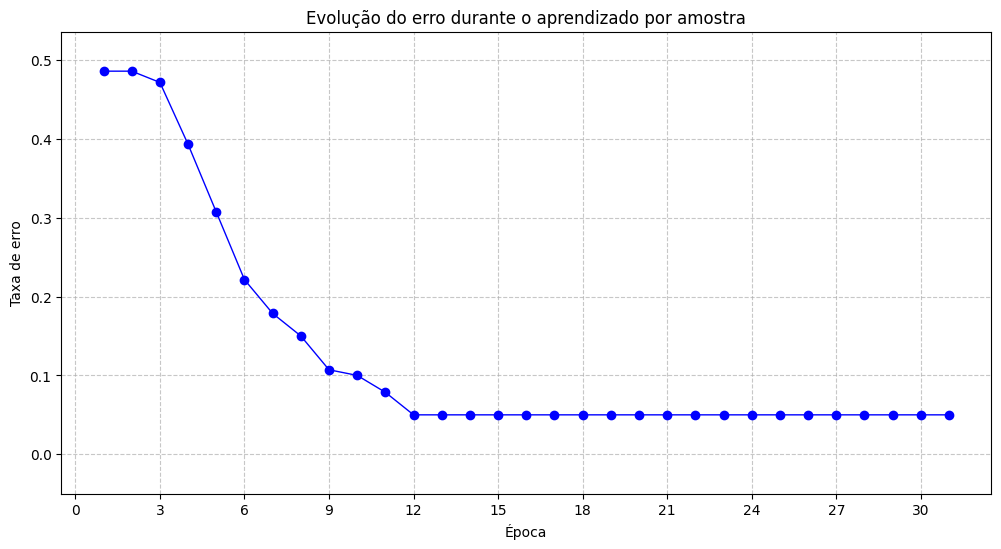

In [140]:
# Aprendizado por amostra
x = np.array(range(1, resultado_treino_amostra[1] + 1))
y = resultado_treino_amostra[2]

plt.figure(figsize=(12, 6))
plt.plot(x, y, 'b-o', linewidth=1, markersize=5, markeredgewidth=2)
plt.title('Evolução do erro durante o aprendizado por amostra', fontsize=12)
plt.xlabel('Época', fontsize=10)
plt.ylabel('Taxa de erro', fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(np.arange(0, max(x)+1, max(1, len(x)//10)))
plt.ylim(-0.05, min(1.05, max(y)+0.05))
plt.show()

##### 3.1.4 Testando o ADALINE

###### 3.1.4.1 Aprendizado por lote

In [141]:
resultado_teste_lote = teste(X_test_1, y_test_1, resultado_treino_lote[0])
print(f"Acurácia no teste por lote: {resultado_teste_lote:.3%}")

Acurácia no teste por lote: 93.333%


###### 3.1.4.1 Aprendizado por amostra

In [142]:
resultado_teste_amostra = teste(X_test_1, y_test_1, resultado_treino_amostra[0])
print(f"Acurácia no teste por lote: {resultado_teste_amostra:.3%}")

Acurácia no teste por lote: 93.333%
